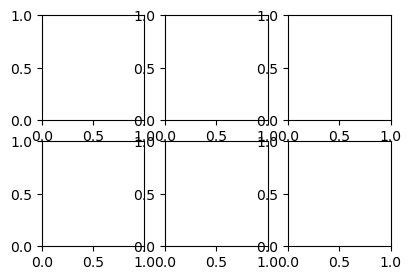

In [2]:
# %matplotlib inline
# import torchvision
# from torch import nn
# from PIL import Image
import matplotlib.pyplot as plt
num_rows = 2
num_cols = 3
scale = 1.5
figsize = (num_cols * scale, num_rows * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()
for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)